## Yêu cầu bài toán
- Dưa vào dữ liệu train, dự đoán trên tập dữ liệu test xem nhân viên nào sẽ nghỉ việc (trường 'Attrition') 
- Tìm xem đâu là nguyên nhân chính làm cho nhân viên nghỉ việc
- Thử nghiệm một chính sách về nhân sự để giữ chân nhân viên và xem coi nó ảnh hưởng thế nào

## Dữ liệu:
- train.csv với kích thước (1000,27): Dùng để huấn luyện mô hình
- test.csv với kích thước (470,26) : Dùng để dự đoán

## Mục tiêu đạt được sau khi làm bài lab:
- Hiểu được qui trình cơ bản khi làm một bài classification dùng tree
- Biết cách visualize dữ liệu cơ bản
- Biết tính độ tương quan giữa các feature
- Biết xử lý category
- Biết xây dựng model và so sánh độ chính xác của model với các model xây dựng bằng thuật toán khác.
- Đọc được kết quả của model và visualize nó
- Biết sử dụng model để làm công cụ dự báo và thử nghiệm giả thuyết

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None) 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Đọc dữ liệu train và test, lưu vào dataframe


In [0]:
X_raw = pd.read_csv('drive/My Drive/Colab Notebooks/cotai/DecisionTree/train.csv', index_col='EmployeeNumber')
X_test = pd.read_csv('drive/My Drive/Colab Notebooks/cotai/DecisionTree/test.csv', index_col='EmployeeNumber')

X_raw['Attrition'] = X_raw['Attrition'].map({'Yes':1,'No':0})

y = X_raw.Attrition
X_full = X_raw.drop(columns=['Attrition'])

cols_cat = [x for x in X_full.columns if (X_full[x].dtypes=='object')]
cols_num = [x for x in X_full.columns if (X_full[x].dtypes!='object')]

print(X_full.shape)
X_full.head(10)

(1000, 26)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,
1,41,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,Sales Executive,4,Single,5993,8,Yes,11,3,1,0,8,0,1,6,4,0,5
2,49,Travel_Frequently,Research & Development,8,1,Life Sciences,1,3,Male,Research Scientist,2,Married,5130,1,No,23,4,4,1,10,3,3,10,7,1,7
4,37,Travel_Rarely,Research & Development,2,2,Other,1,4,Male,Laboratory Technician,3,Single,2090,6,Yes,15,3,2,0,7,3,3,0,0,0,0
5,33,Travel_Frequently,Research & Development,3,4,Life Sciences,1,4,Female,Research Scientist,3,Married,2909,1,Yes,11,3,3,0,8,3,3,8,7,3,0
7,27,Travel_Rarely,Research & Development,2,1,Medical,1,1,Male,Laboratory Technician,2,Married,3468,9,No,12,3,4,1,6,3,3,2,2,2,2
8,32,Travel_Frequently,Research & Development,2,2,Life Sciences,1,4,Male,Laboratory Technician,4,Single,3068,0,No,13,3,3,0,8,2,2,7,7,3,6
10,59,Travel_Rarely,Research & Development,3,3,Medical,1,3,Female,Laboratory Technician,1,Married,2670,4,Yes,20,4,1,3,12,3,2,1,0,0,0
11,30,Travel_Rarely,Research & Development,24,1,Life Sciences,1,4,Male,Laboratory Technician,3,Divorced,2693,1,No,22,4,2,1,1,2,3,1,0,0,0
12,38,Travel_Frequently,Research & Development,23,3,Life Sciences,1,4,Male,Manufacturing Director,3,Single,9526,0,No,21,4,2,0,10,2,3,9,7,1,8


# 2. Tìm hiểu về dữ liệu
## 2.1 Xem dữ bằng đồ thị

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


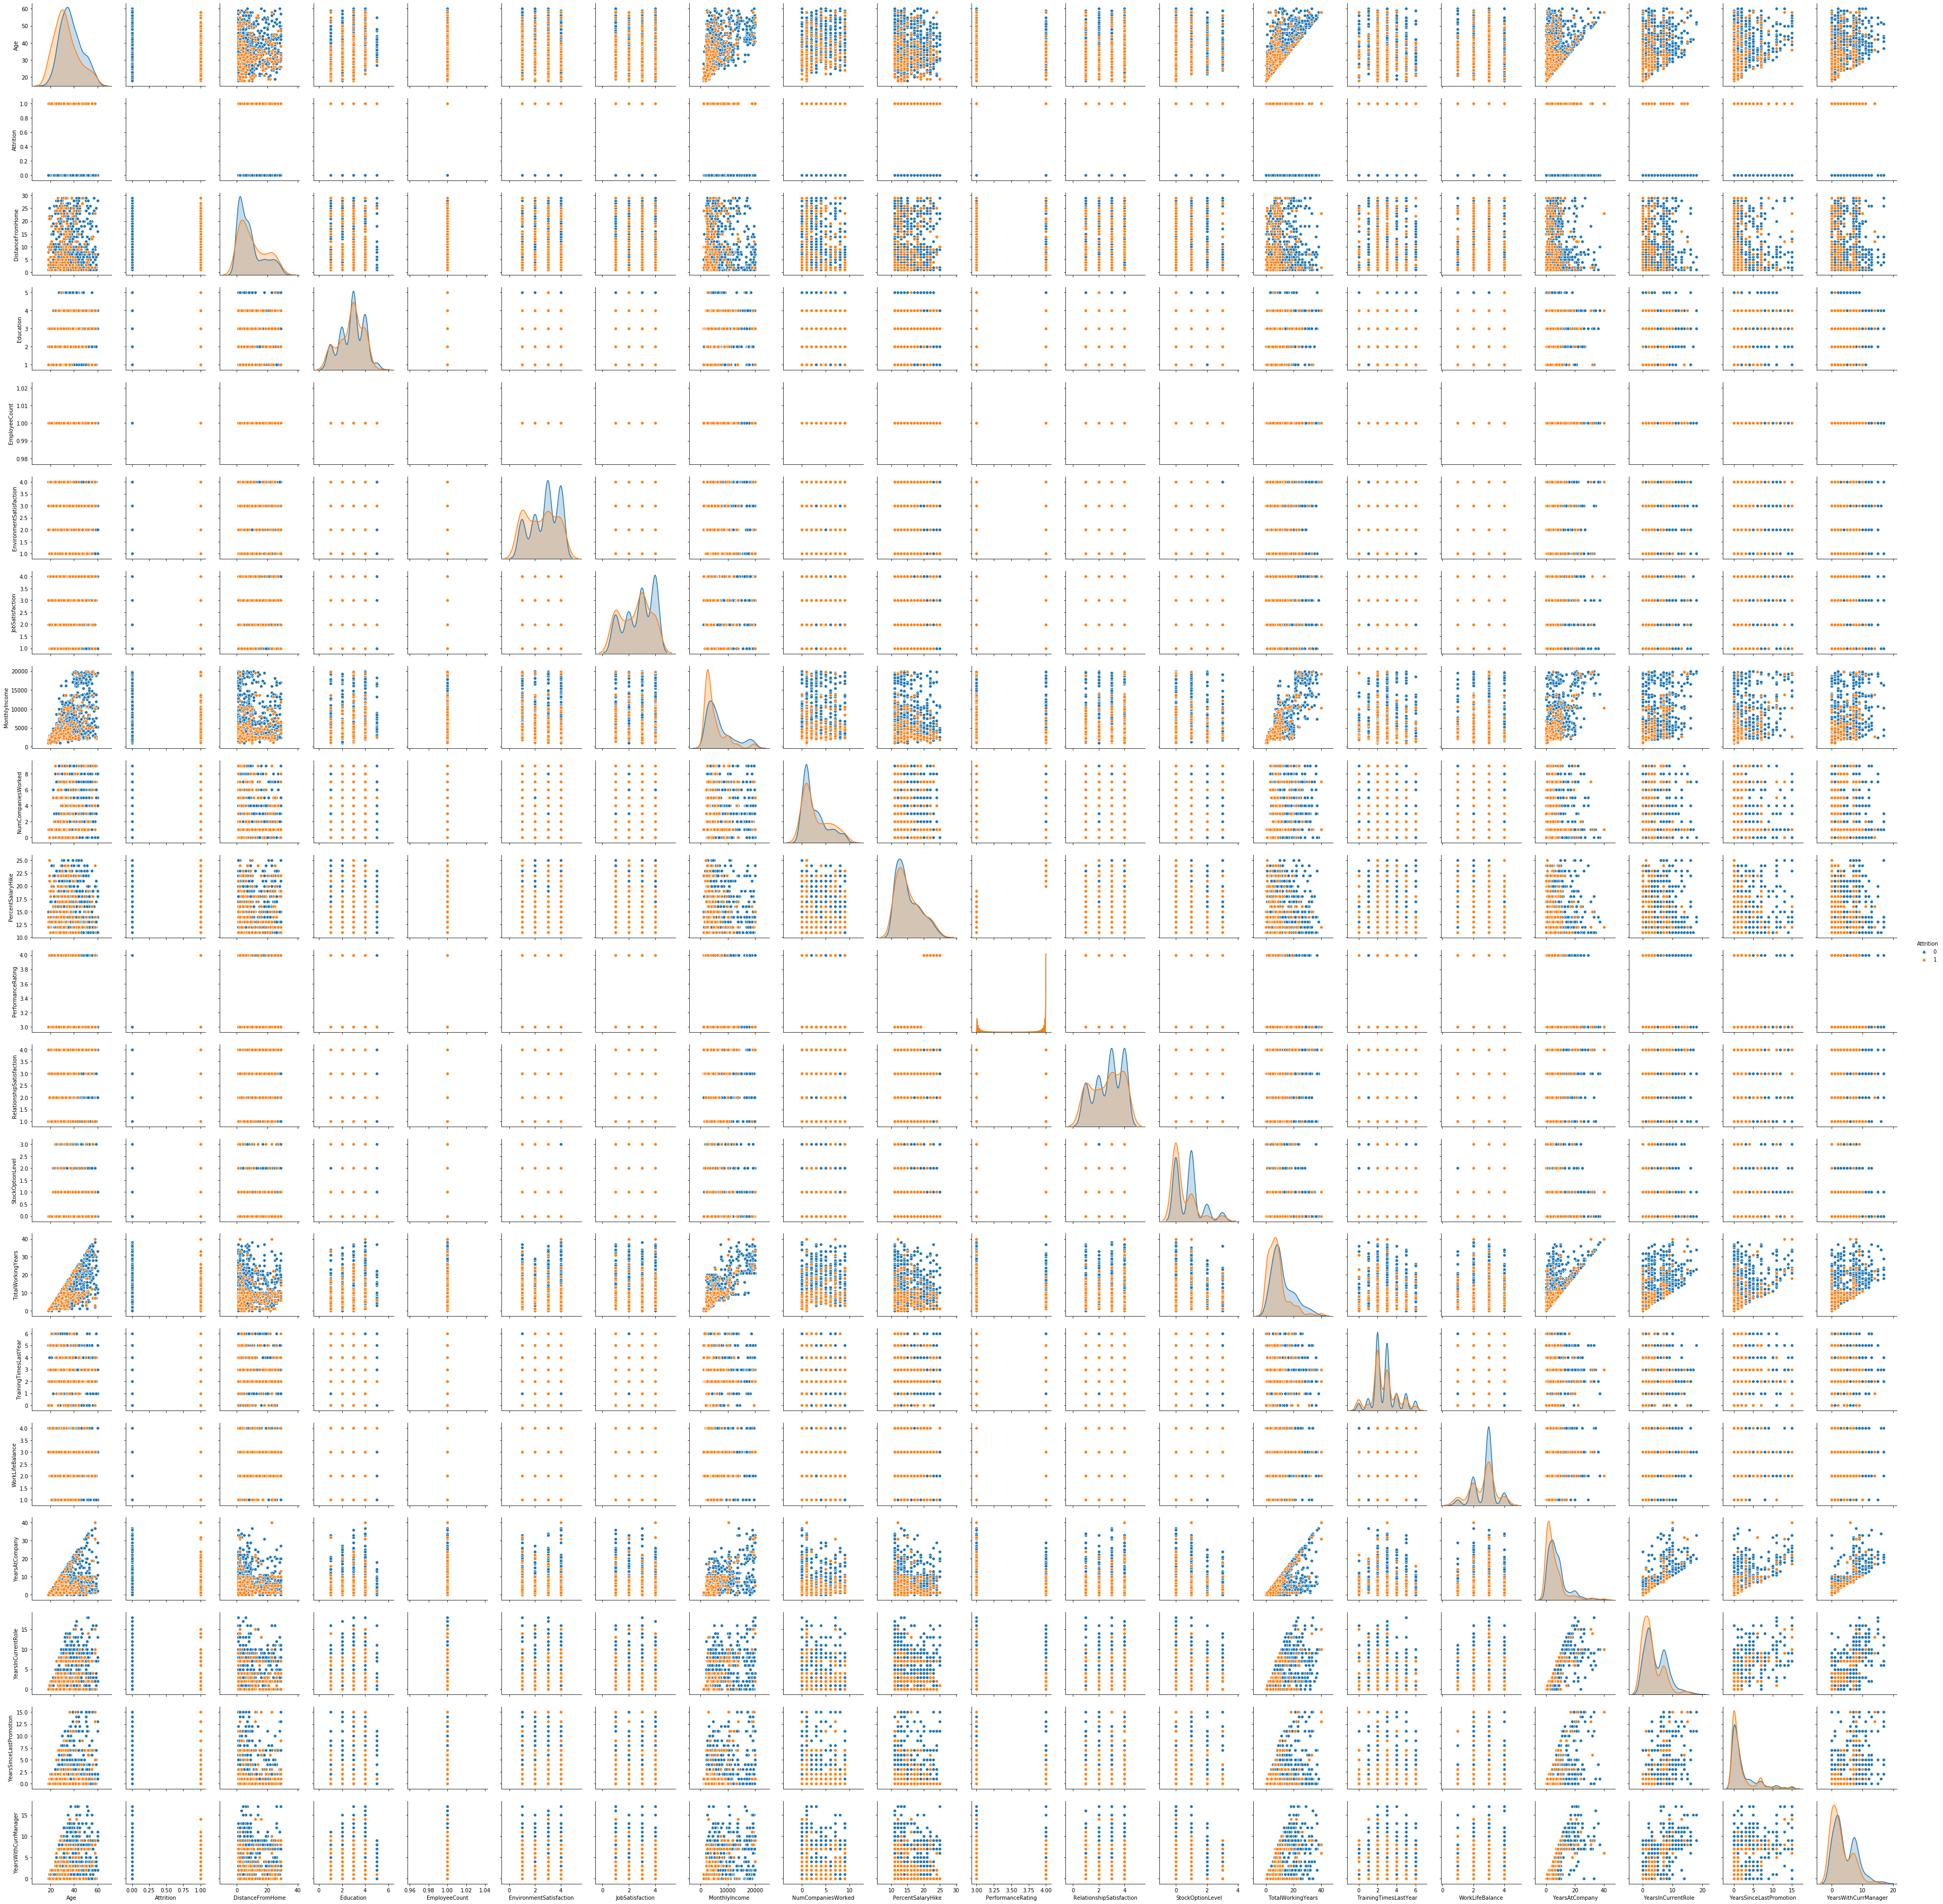

In [0]:
sns.pairplot(data=X_raw, hue='Attrition')

## 2.2 Mối tương quan giữa các biến đầu vào dùng Pearson correlation
$$ r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}$$

In [0]:
X_full[cols_num].corr()

,Age,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,-0.018776,0.182582,NaN,0.035695,-0.022625,0.505284,0.312032,-0.044510,-0.053793,0.053249,0.003061,0.690203,-0.005170,-0.029218,0.316925,0.205668,0.215158,0.199571
DistanceFromHome,-0.018776,1.000000,0.021307,NaN,-0.022899,0.006346,-0.045598,-0.017844,0.043278,0.030998,0.015248,0.051631,-0.022563,-0.007602,-0.055194,-0.028068,-0.001148,-0.009895,-0.009326
Education,0.182582,0.021307,1.000000,NaN,0.009408,0.004871,0.091692,0.124625,-0.016113,-0.034090,0.007871,-0.009772,0.132150,-0.040701,0.014913,0.062936,0.075918,0.080601,0.093444
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EnvironmentSatisfaction,0.035695,-0.022899,0.009408,NaN,1.000000,0.016704,-0.004776,-0.004252,-0.066280,-0.044962,-0.016709,0.009914,0.006842,-0.035961,0.033415,-0.004355,0.023520,0.017404,-0.011404
JobSatisfaction,-0.022625,0.006346,0.004871,NaN,0.016704,1.000000,-0.035175,-0.064331,0.001832,-0.021260,-0.012423,0.025072,-0.046123,0.014282,-0.062323,-0.039150,-0.026454,-0.047373,-0.051252
MonthlyIncome,0.505284,-0.045598,0.091692,NaN,-0.004776,-0.035175,1.000000,0.150945,-0.068754,-0.061870,0.026040,0.004718,0.780205,-0.003869,0.020385,0.527463,0.376103,0.347272,0.347135
NumCompaniesWorked,0.312032,-0.017844,0.124625,NaN,-0.004252,-0.064331,0.150945,1.000000,0.000509,0.003167,0.037947,0.005659,0.250892,-0.051385,0.008657,-0.103055,-0.075352,-0.024038,-0.092171
PercentSalaryHike,-0.044510,0.043278,-0.016113,NaN,-0.066280,0.001832,-0.068754,0.000509,1.000000,0.772665,-0.046371,-0.013512,-0.065660,-0.017195,-0.049206,-0.066833,-0.027409,-0.043352,-0.037266
PerformanceRating,-0.053793,0.030998,-0.034090,NaN,-0.044962,-0.021260,-0.061870,0.003167,0.772665,1.000000,-0.010484,-0.004466,-0.035706,-0.023329,-0.045671,-0.025575,0.017563,-0.002677,0.002388


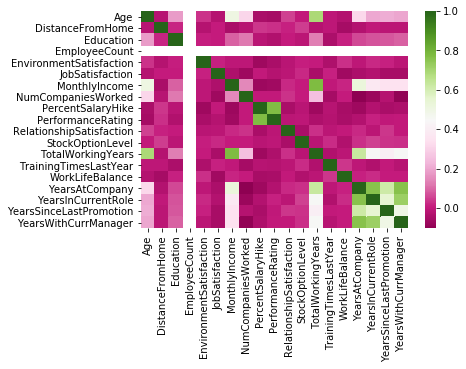

In [0]:
sns.heatmap(X_full[cols_num].corr(),cmap="PiYG")

# 3. Xử lý category
- Có nhiều phương pháp như label encoding, onehot encoding, count encoding, target encoding, v.v. Tùy vào dữ liệu mà mỗi phương pháp sẽ có ưu nhược điểm khác nhau. Xem thêm thư viện xử lý categories của sklearn nếu muốn tìm hiểu sâu hơn.
- Để đơn giản hóa, ta dùng onehot encoding trong bài này

In [0]:
X_full_merge = pd.concat([X_full[cols_num],pd.get_dummies(data=X_full[cols_cat])],axis=1)
X_test_merge = pd.concat([X_test[cols_num],pd.get_dummies(data=X_test[cols_cat])],axis=1)
print(X_full_merge.shape)
X_full_merge.head(3)

(1000, 47)


,Age,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,41,1,2,1,2,4,5993,8,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2,49,8,1,1,3,2,5130,1,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
4,37,2,2,1,4,3,2090,6,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1


# 4. Xây dựng model
- Sử dụng Deep Learning
- Sử dụng thuật toán Decision Tree
- Sử dụng thuật toán Random Forest (ensemble của decision tree)
- So sánh

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_mlp = Sequential()
model_mlp.add(Dense(47, input_dim=47, activation='relu'))
model_mlp.add(Dense(47, activation='relu'))
model_mlp.add(Dense(10, activation='relu'))
model_mlp.add(Dense(1, activation='sigmoid'))
model_mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mlp.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 47)                2256      
_________________________________________________________________
dense_5 (Dense)              (None, 47)                2256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                480       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 5,003
Trainable params: 5,003
Non-trainable params: 0
_________________________________________________________________


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

np.random.seed(5)
X_train, X_valid, y_train, y_valid = train_test_split(X_full_merge, y, random_state=0,test_size=0.2)

model_decisiontree = DecisionTreeClassifier(criterion="entropy", max_depth = 4, random_state = 0)
model_randomforest = RandomForestClassifier(criterion='entropy', max_depth=4, random_state=0,n_estimators=300)

model_decisiontree.fit(X_train, y_train)
model_randomforest.fit(X_train, y_train)
model_mlp.fit(X_train, y_train,epochs=5,validation_split=0.25)

print('Decision Tree score: ' + str(model_decisiontree.score(X_valid, y_valid)))
print('Random forest score: ' + str(model_randomforest.score(X_valid, y_valid)))

Train on 600 samples, validate on 200 samples
Epoch 1/5
600/600 [==============================] - 0s 245us/sample - loss: 65.5751 - acc: 0.6467 - val_loss: 15.1970 - val_acc: 0.8600
Epoch 2/5
600/600 [==============================] - 0s 103us/sample - loss: 6.9674 - acc: 0.7717 - val_loss: 1.7272 - val_acc: 0.8600
Epoch 3/5
600/600 [==============================] - 0s 96us/sample - loss: 1.2394 - acc: 0.7733 - val_loss: 0.4312 - val_acc: 0.8600
Epoch 4/5
600/600 [==============================] - 0s 90us/sample - loss: 0.8044 - acc: 0.7917 - val_loss: 0.4112 - val_acc: 0.8600
Epoch 5/5
600/600 [==============================] - 0s 85us/sample - loss: 0.6757 - acc: 0.7967 - val_loss: 0.9841 - val_acc: 0.8600
Decision Tree score: 0.83
Random forest score: 0.835


In [0]:
# feature importance
def drawFeatureImportance(model, title, n_top):
  importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
  importances = importances.sort_values('importance',ascending=False).head(n_top)
  sns.barplot(y=importances['feature'],x=importances['importance']).set_title(title)
  

## Những feature có ảnh hưởng mạnh nhất đến kết quả dự đoán

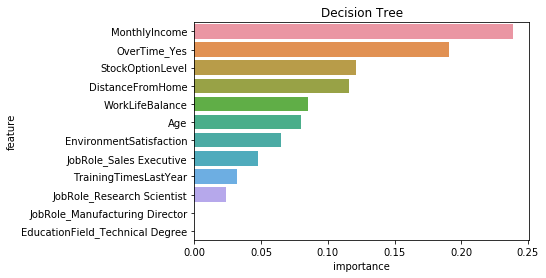

In [0]:
drawFeatureImportance(model_decisiontree, 'Decision Tree',12)

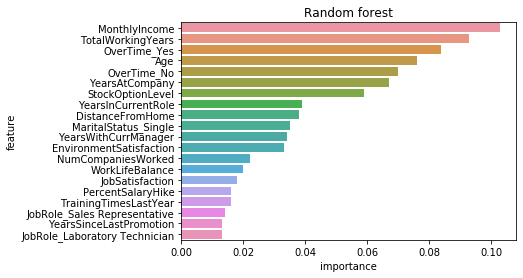

In [0]:
drawFeatureImportance(model_randomforest, 'Random forest',20)

In [0]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# draw tree
def drawTree(model):
  dot_data = StringIO()
  export_graphviz(model, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True,
                  feature_names = X_train.columns,
                  class_names=[str(x) for x in model.classes_]
                  )
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return graph.create_png()

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSYsJGqOEwiOVOFHnbeIgzmXCwgAKImInIUl9zWVQxUHEYbLM0s9Q&s)
# **Câu hỏi**: Nhìn vào hình vẽ, hãy tìm ra những điều kiện dẫn đến một người phải nghỉ việc /  không muốn nghỉ việc

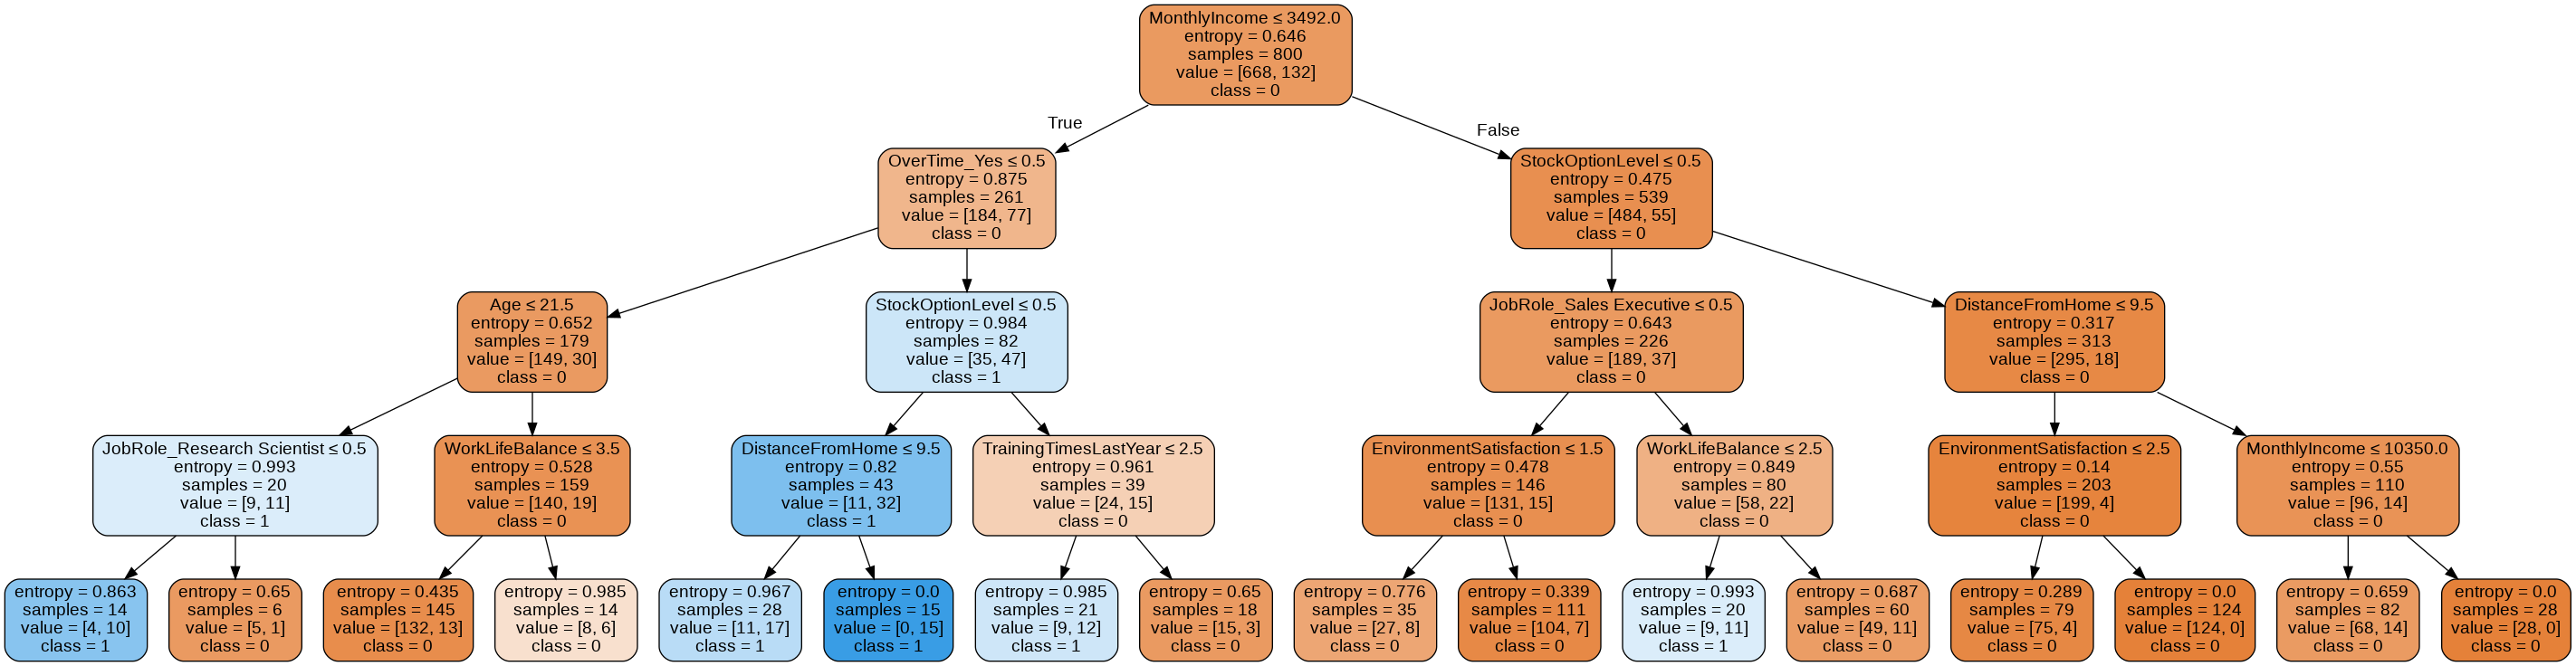

In [0]:
Image(drawTree(model_decisiontree))

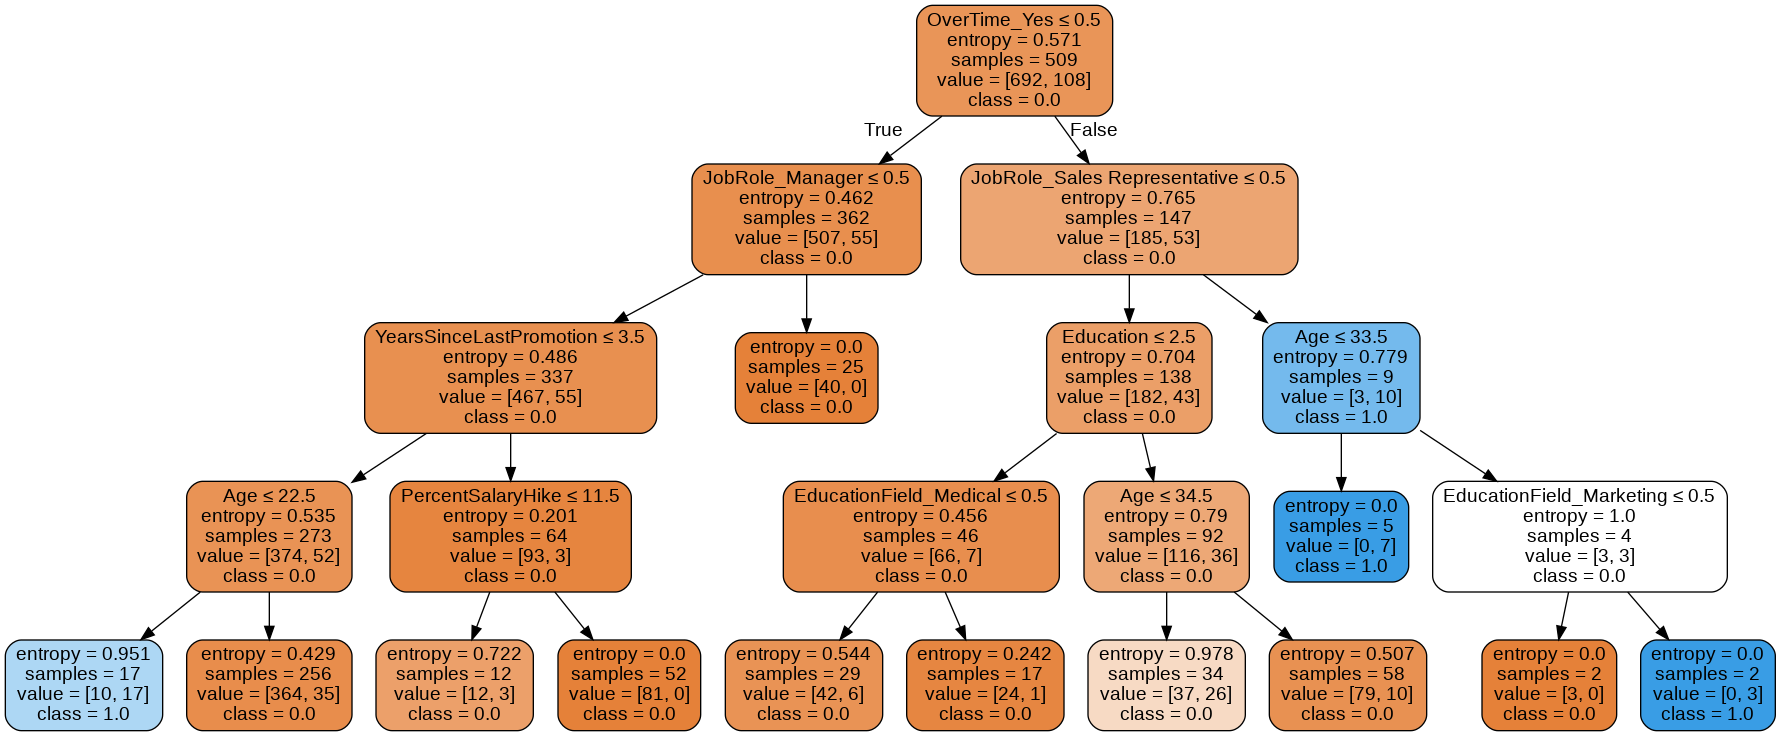

In [0]:
Image(drawTree(model_randomforest.estimators_[100]))

## ROC & AUC
Một số khái niệm:
- True Possitive (TP): Sự kiện xảy ra và ta dự báo có xảy ra
- False Possitive (FP): Sử kiện có xảy ra và ta dự báo không xảy ra
- True Negative (TN): Sự kiện không xảy ra và ta dự báo có xảy ra
- False Negative (FN): Sự kiện không xảy ra và ta dự báo không xảy ra

Vây ta sẽ tính tỉ lệ đoán trúng (true possitive rate) và tỉ lệ đoán trật (false possitive rate) như sau:

$$ TPR = \frac{TP}{TP+FN}$$
$$ FPR = \frac{FP}{FP+TN}$$

No Skill: ROC AUC=0.500
With mlp: ROC AUC=0.571
With decision tree: ROC AUC=0.627
With random forest: ROC AUC=0.740
Best: ROC AUC=1.000


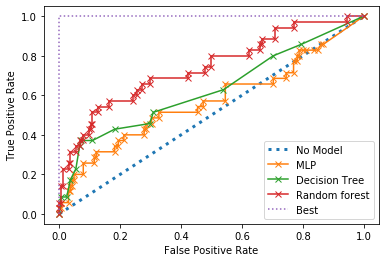

In [0]:
# ROC & AUC
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot

# pred_proba = model.predict_proba(X_valid)
# print('AUC: ' + str(roc_auc_score(y_valid, pred_proba[:,1])))

nomodel_probs = [0 for _ in range(len(y_valid))]
mlp_probs = model_mlp.predict(X_valid)[:, 0]
decisiontree_probs = model_decisiontree.predict_proba(X_valid)[:, 1]
randomforest_probs = model_randomforest.predict_proba(X_valid)[:, 1]
best_probs = [x for x in y_valid]

nomodel_auc = roc_auc_score(y_valid, nomodel_probs)
mlp_auc = roc_auc_score(y_valid, mlp_probs)
decisiontree_auc = roc_auc_score(y_valid, decisiontree_probs)
randomforest_auc = roc_auc_score(y_valid, randomforest_probs)
best_auc = roc_auc_score(y_valid, best_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (nomodel_auc))
print('With mlp: ROC AUC=%.3f' % (mlp_auc))
print('With decision tree: ROC AUC=%.3f' % (decisiontree_auc))
print('With random forest: ROC AUC=%.3f' % (randomforest_auc))
print('Best: ROC AUC=%.3f' % (best_auc))

# calculate roc curves
nomodel_fpr, nomodel_tpr, _ = roc_curve(y_valid, nomodel_probs)
mlp_fpr, mlp_tpr, _ = roc_curve(y_valid, mlp_probs)
decisiontree_fpr, decisiontree_tpr, _ = roc_curve(y_valid, decisiontree_probs)
randomforest_fpr, randomforest_tpr, _ = roc_curve(y_valid, randomforest_probs)
best_fpr, best_tpr, _ = roc_curve(y_valid, best_probs)

# plot the roc curve for the model
pyplot.plot(nomodel_fpr, nomodel_tpr, linestyle=':',linewidth=3, label='No Model')
pyplot.plot(mlp_fpr, mlp_tpr, marker='x', label='MLP')
pyplot.plot(decisiontree_fpr, decisiontree_tpr, marker='x', label='Decision Tree')
pyplot.plot(randomforest_fpr, randomforest_tpr, marker='x', label='Random forest')
pyplot.plot(best_fpr, best_tpr, linestyle=':', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# **Hãy giải thích vì sao random forest lại tốt hơn MLP trong trường hợp (bài toán) này trong khi neuron network là thuật toán hiện đại và được đánh giá cao?**

![alt text](https://www.researchgate.net/profile/Benoit_Gallix/publication/324457640/figure/fig1/AS:622298201595905@1525378861825/Graph-illustrating-the-impact-of-data-available-on-performance-of-traditional-machine.png)

# 5. Dự báo người sẽ nghỉ việc

In [0]:
predict = model_randomforest.predict(X_test_merge)
predict = pd.DataFrame({'EmployeeNumber':X_test.index,'Attrition':predict})
predict = predict.merge(X_test,on='EmployeeNumber')
predict.head(3)

,EmployeeNumber,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1409,0,52,Travel_Rarely,Research & Development,8,4,Other,1,3,Female,Laboratory Technician,1,Married,2950,9,No,13,3,3,0,12,2,1,5,4,0,4
1,1411,0,37,Travel_Rarely,Research & Development,11,3,Medical,1,1,Female,Laboratory Technician,3,Single,3629,4,No,18,3,1,0,8,6,3,3,2,0,2
2,1412,0,35,Travel_Frequently,Research & Development,18,2,Life Sciences,1,3,Male,Manufacturing Director,4,Single,9362,2,No,11,3,3,0,10,2,3,2,2,2,2


# 6. Thử nghiệm một chính sách về nhân sự

## Danh sách những người dự báo sẽ nghỉ

In [0]:
X_policy = X_valid.copy(True)
y_policy = model_randomforest.predict(X_policy)
y_policy = pd.DataFrame({'EmployeeNumber':X_policy.index,'Attrition':y_policy})
print(y_policy[y_policy.Attrition==1].shape)

y_policy[y_policy.Attrition==1]



(4, 2)


,EmployeeNumber,Attrition
84,1269,1
115,514,1
156,614,1
162,959,1


## Thực thi một chính sách về nhân sự

In [0]:
X_policy = X_policy[X_policy.index.isin([614, 622, 1273, 959])]
X_policy

,Age,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
614,18,5,3,1,2,2,1878,1,14,3,4,0,0,3,3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1
959,19,21,3,1,4,2,2121,1,13,3,2,0,1,3,4,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [0]:
# X_policy['MonthlyIncome'] = X_policy['MonthlyIncome']*1.1 
X_policy['OverTime_No'] = 1
X_policy['OverTime_Yes'] = 0
X_policy


,Age,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
614,18,5,3,1,2,2,1878,1,14,3,4,0,0,3,3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0
959,19,21,3,1,4,2,2121,1,13,3,2,0,1,3,4,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0


In [0]:
model_randomforest.predict(X_policy)

array([0, 0])

## **Kết quả: Nếu bỏ chính sách overtime trong doanh nghiệp thì 4 người này sẽ ở lại doanh nghiệp**